In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from time import time

In [2]:
data = pd.read_csv('/kaggle/input/imdb-ptbr/imdb-reviews-pt-br.csv', index_col=0)

le = preprocessing.LabelEncoder()
categorical_sentiment = le.fit_transform(data['sentiment'])

# split in a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(data['text_pt'], categorical_sentiment, test_size=0.25, random_state=1)

# Extracting features from the training data using a sparse vectorizer
t0 = time()
vectorizer = TfidfVectorizer(
    sublinear_tf=True, max_df=0.1, min_df=2)
#     sublinear_tf=True, max_df=0.5, min_df=2, analyzer='char', ngram_range=(2,5))

X_train = vectorizer.fit_transform(X_train)
duration_train = time() - t0

# Extracting features from the test data using the same vectorizer
t0 = time()
X_test = vectorizer.transform(X_test)
duration_test = time() - t0

feature_names = vectorizer.get_feature_names_out()

X_train, X_test, y_train, y_test, feature_names

# remover
X_train = X_train[:1000]
X_test = X_test[:1000]
y_train = y_train[:1000]
y_test = y_test[:1000]

In [3]:
vectorizer.vocabulary_

{'sexploitation': 56625,
 'sessenta': 56573,
 'início': 34943,
 'setenta': 56584,
 'começou': 13086,
 'concessão': 13577,
 'nudez': 44382,
 'gratuita': 29881,
 'principais': 49621,
 'terminou': 60944,
 'hardcore': 30697,
 'porn': 48645,
 'pico': 47816,
 '1968': 258,
 '1972': 262,
 'atrizes': 5880,
 'amadas': 3008,
 'talentosas': 60261,
 'época': 66605,
 'monica': 42266,
 'gayle': 28794,
 'pequeno': 47082,
 'fanático': 26065,
 'culto': 15923,
 'seguidores': 56060,
 'capaz': 10179,
 'agir': 2128,
 'contrário': 14619,
 'preencheram': 49124,
 'papéis': 46112,
 'desses': 18791,
 'créditos': 15789,
 'subsequentes': 59204,
 'provaram': 50210,
 'aparente': 4050,
 'deliberado': 17124,
 'desvanecer': 18894,
 'carreira': 10530,
 'dela': 17093,
 'decolando': 16822,
 'aumenta': 6023,
 'mística': 43217,
 'gary': 28707,
 'graver': 29915,
 'talento': 60258,
 'talentoso': 60262,
 'gênero': 30417,
 'habilidade': 30443,
 'combinada': 12939,
 'presença': 49356,
 'tela': 60606,
 'sandra': 55383,
 'making':

In [4]:
#CategoricalNB, ExtraTreesClassifier, GradientBoostingClassifier, MLPClassifier, SVC, RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report

predictions = []

clf = GradientBoostingClassifier()
clf.fit(X_train.toarray(), y_train)

y_prob_train = clf.predict_proba(X_train.toarray())
y_prob_test = clf.predict_proba(X_test)

y_pred_train = clf.predict(X_train.toarray())
y_pred_test = clf.predict(X_test)
                                   
predictions.append({
    'name': 'GradientBoosting',
    'y_prob_test': y_prob_test,   #previsão probabilistica
    'y_pred_test': y_pred_test,   #previsão categorica
    'y_test': y_test,             #verdadeiros
})

clf = ExtraTreesClassifier()
clf.fit(X_train.toarray(), y_train)

y_prob_train = clf.predict_proba(X_train.toarray())
y_prob_test = clf.predict_proba(X_test)

y_pred_train = clf.predict(X_train.toarray())
y_pred_test = clf.predict(X_test)
                                   
predictions.append({
    'name': 'ExtraTreesClassifier',
    'y_prob_test': y_prob_test,   #previsões probabilisticas
    'y_pred_test': y_pred_test,   #previsões categoricas
    'y_test': y_test,             #verdadeiros
})

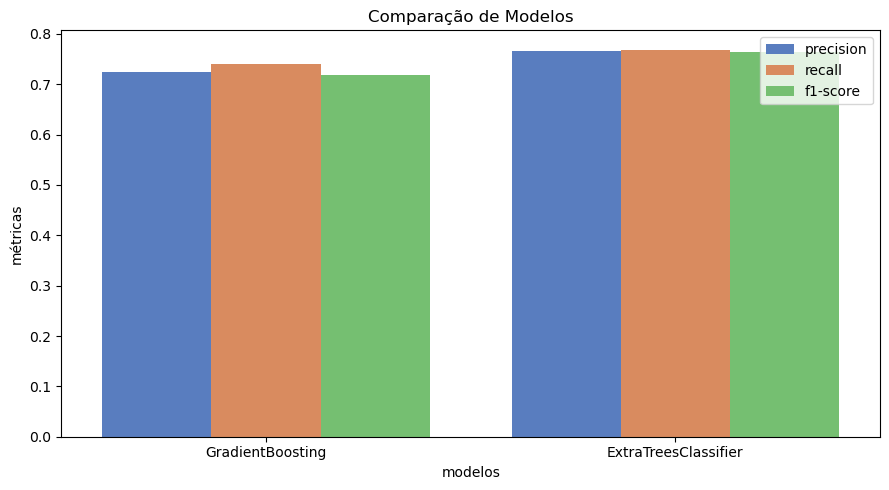

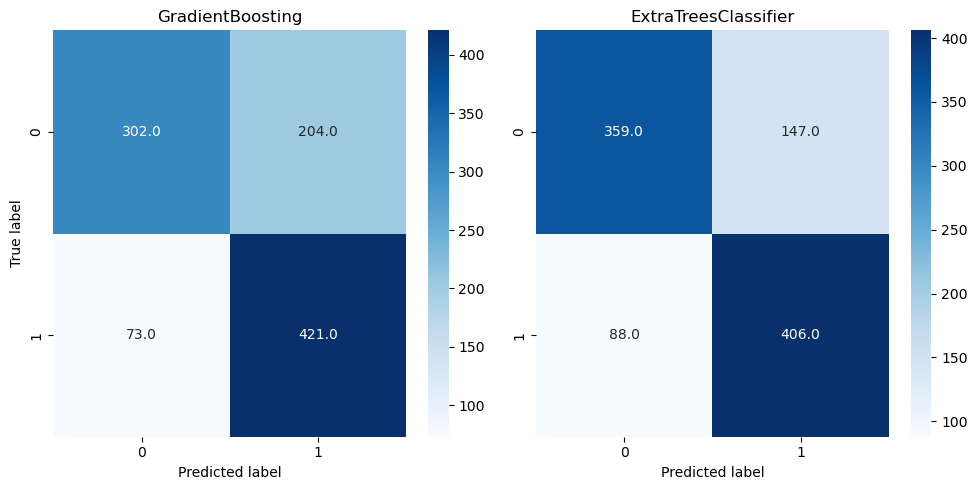

In [5]:
# aceita predictions no formato:
# [
#     {
#         'name': 'model name',
#         'y_prob_test': [0.7, 0.2, 0.9, ...],   #previsões probabilisticas
#         'y_pred_test': [1, 0, 1, ...],         #previsões categoricas
#         'y_test': [1, 1, 0, ...]               #verdadeiros
#     },
#     {
#         'name': 'model name 2',
#         'y_prob_test': [0.7, 0.2, 0.9, ...],   #previsões probabilisticas
#         'y_pred_test': [1, 0, 1, ...],         #previsões categoricas
#         'y_test': [1, 1, 0, ...]               #verdadeiros
#     },
# ]

def calcula_metricas_mostra_graficos(predictions):
    metrics_df = []
    cm = []
    for p in predictions:
        report = classification_report(p['y_pred_test'], p['y_test'], output_dict=True)
        metrics_df.append([p['name'], report['macro avg']['precision'], report['macro avg']['recall'], report['macro avg']['f1-score']])
        cm.append((p['name'], confusion_matrix(p['y_test'], p['y_pred_test'])))
        
    metrics_df = pd.DataFrame(metrics_df, columns=['name','precision', 'recall', 'f1-score'])
    df_melted = pd.melt(metrics_df, id_vars=['name'], var_name='metric', value_name='score')
    
    fig, axes = plt.subplots(figsize=(9, 5))
    sns.set_palette('muted')
    
    sns.barplot(x='name', y='score', hue='metric', data=df_melted)
    axes.set_xlabel('modelos')
    axes.set_ylabel('métricas')
    axes.set_title('Comparação de Modelos')
    axes.legend(loc='best')
    
    fig.tight_layout()
    plt.show()
    
    name0, cm0 = cm[0]
    name1, cm1 = cm[1]
    
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
    sns.heatmap(cm0, annot=True, cmap='Blues', ax=axs[0], fmt='.1f')
    sns.heatmap(cm1, annot=True, cmap='Blues', ax=axs[1], fmt='.1f')
    axs[0].set_title(name0)
    axs[1].set_title(name1)
    axs[0].set_ylabel('True label')
    axs[0].set_xlabel('Predicted label')
    axs[1].set_xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
        
        
calcula_metricas_mostra_graficos(predictions)